In [3]:
pip install tensorflow pandas numpy matplotlib scikit-learn


In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
data_path = "/content/drive/MyDrive/dataset_new_equal"

In [5]:
dataset = image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(150, 150),
    batch_size=32,
)
val_dataset = image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(150, 150),
    batch_size=32,
)


Found 2311 files belonging to 6 classes.
Using 1849 files for training.
Found 2311 files belonging to 6 classes.
Using 462 files for validation.


In [6]:
class_names = dataset.class_names
print(f"Class names: {class_names}")

Class names: ['W_CL_03_Commelina benghalensis', 'W_CL_06_Ipomoea aquatic', 'W_CL_07_Marsilea minuta', 'W_CL_09_Paspalum scrobiculatum', 'W_CL_10_Pteris vittata', 'W_CL_11_Synedrella nodiflora']


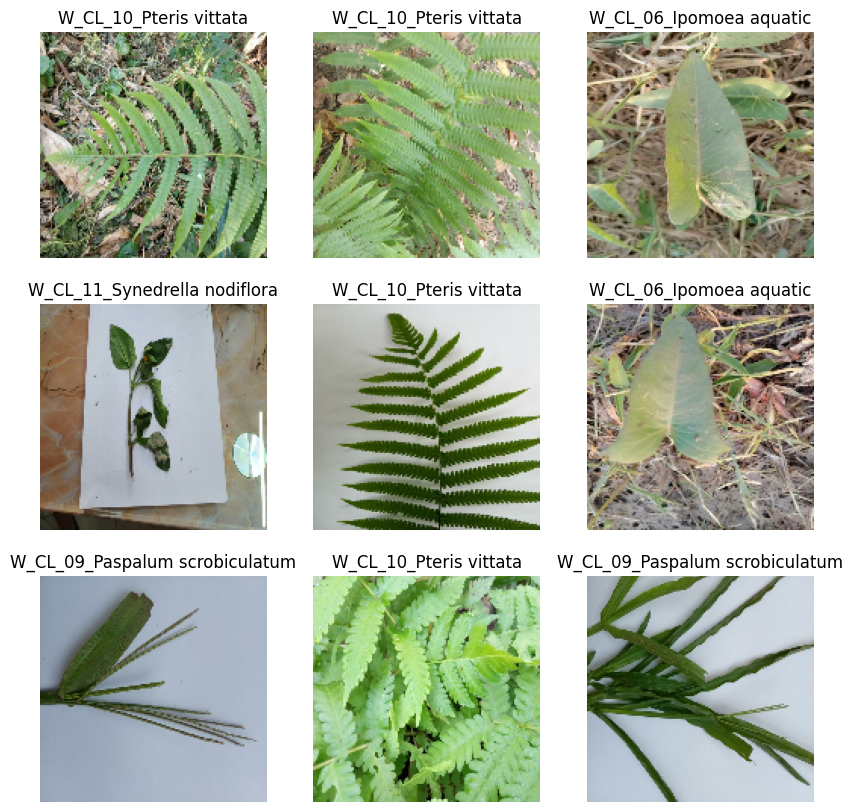

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [8]:
normalization_layer = layers.Rescaling(1.0 / 255)

dataset = dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))


In [10]:
import tensorflow as tf


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)


In [12]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')  # Output layer for 6 classes
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [14]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,735,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,829,126 (18.42 MB)

 Trainable params: 4,829,126 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [16]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[early_stopping]
)


Epoch 1/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 318s 1s/step - accuracy: 0.2267 - loss: 1.9981 - val_accuracy: 0.4113 - val_loss: 1.5251
Epoch 2/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4630 - loss: 1.4200 - val_accuracy: 0.5541 - val_loss: 1.1096
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6182 - loss: 1.0005 - val_accuracy: 0.7143 - val_loss: 0.7892
Epoch 4/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7938 - loss: 0.6057 - val_accuracy: 0.7294 - val_loss: 0.6720
Epoch 5/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8838 - loss: 0.4034 - val_accuracy: 0.7641 - val_loss: 0.6605
Epoch 6/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9273 - loss: 0.2087 - val_accuracy: 0.8312 - val_loss: 0.4973
Epoch 7/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9787 - loss: 0.0748 - val_accuracy: 0.8615 - val_loss: 0.4881
Epoch 8/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9811 - loss: 0.0585 - val_accuracy: 0.8355 - v

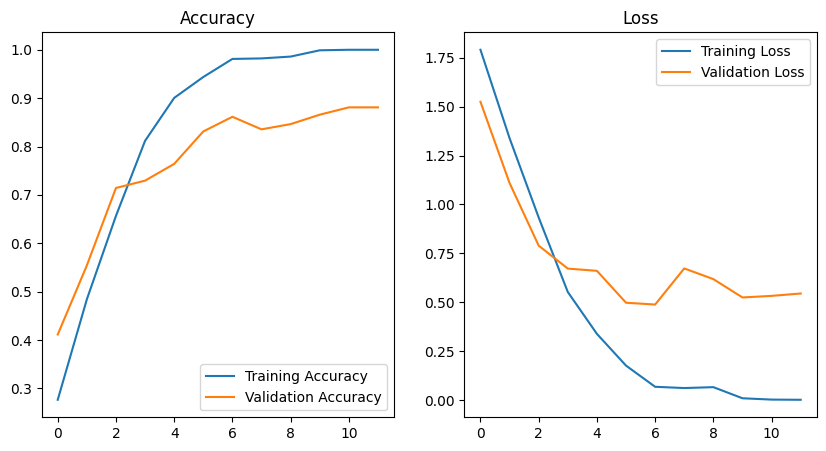

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

In [18]:
test_loss, test_acc = model.evaluate(val_dataset)
print(f"Test Accuracy: {test_acc:.2f}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8345 - loss: 0.5735
Test Accuracy: 0.86


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
Predictions: [0 0 2 5 1 1 1 2 1 0 3 0 4 0 4 1 4 3 1 3 1 0 2 4 5 0 1 3 2 0 5 2]
True Labels: [5 4 2 5 1 1 2 2 0 0 3 5 4 0 3 2 4 3 1 3 5 0 2 4 5 0 1 3 2 0 5 2]


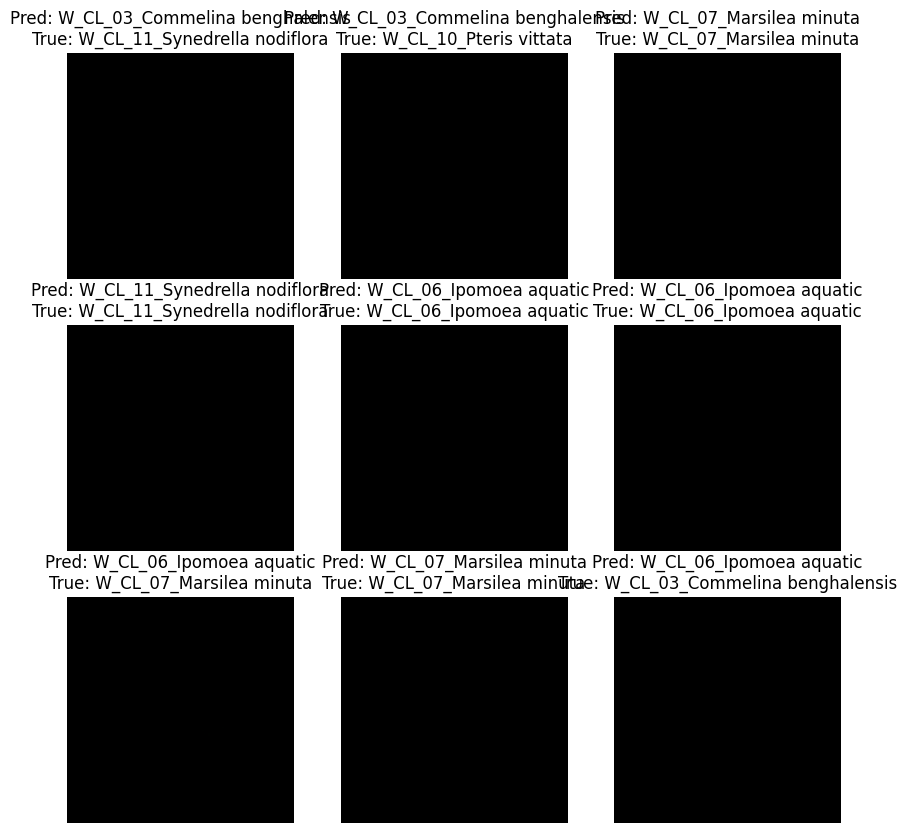

In [19]:
for images, labels in val_dataset.take(1):
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    print(f"Predictions: {predicted_classes}")
    print(f"True Labels: {labels.numpy()}")

    # Display the images with predicted and true labels
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Pred: {class_names[predicted_classes[i]]}\nTrue: {class_names[labels[i]]}")
        plt.axis("off")

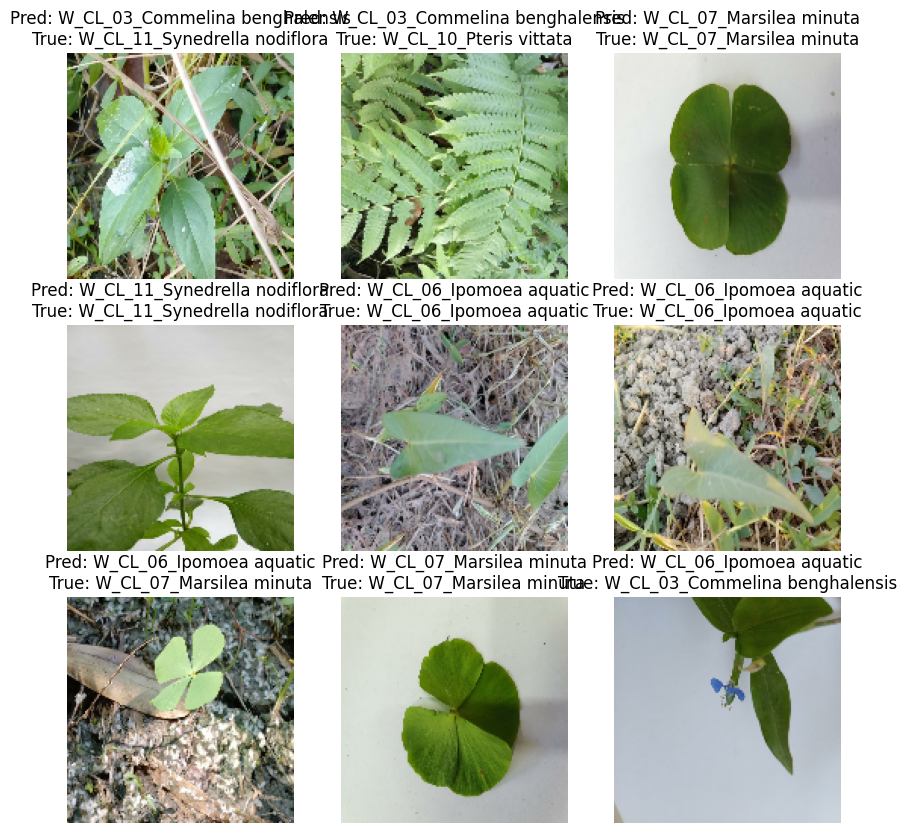

In [20]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)

    img = images[i].numpy()
    img = (img * 255).astype("uint8")  # Rescale to [0, 255]
    plt.imshow(img)
    plt.title(f"Pred: {class_names[predicted_classes[i]]}\nTrue: {class_names[labels[i]]}")
    plt.axis("off")